# Bfastmonitor CPU using Python
## This is bfastmonitor Python

In [1]:
import os
import wget
import numpy as np
from datetime import datetime

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates

import copy

import matplotlib
import matplotlib.pyplot as plt

#from sar so extra
import csv
from shutil import copyfile
import pandas as pd
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import time
import ipywidgets as widgets

from ipyfilechooser import FileChooser
import folium

#specific imports
from functions import set_output_dir, get_size, get_data_dict

In [2]:
%matplotlib inline

## Select a time series folder using ipyfilechooser. The standard download location is in downloads/time_series_name/[0,1,2..n]

### Optional: select a name for your output folder. 

In [4]:
from os.path import expanduser
path = expanduser("~")

def g(directory):
    return(directory)
                          
output_directory_chooser = widgets.interactive(g, 
                        directory=widgets.Text(description="Output storage name:", 
                                               style = {'description_width': 'initial'},
                                               placeholder = "output"))
file_chooser = FileChooser(path)

display(file_chooser)
display(output_directory_chooser)



FileChooser(path='/home/dven', filename='', show_hidden='False')

interactive(children=(Text(value='', description='Output storage name:', placeholder='output', style=Descripti…

In [101]:
timeseries_directory = file_chooser.selected

if not timeseries_directory:
    raise Exception("Please choose a time series directory above with the file selector")
else:
    print(timeseries_directory)
    set_output_dir(output_directory_chooser)

/home/dven/downloads/Time_series_2020-07-06_16-31-46_Portugal_Bigger/1/
Defaulting to output directory name "output" 


In [114]:
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan

from bfast import BFASTMonitor
from bfast.utils import crop_data_dates


class Timeseries:
    '''
    
    This is a class that holds a numpy array with time series data, a csv containing dates, and associated geographical metadata.
    
    '''
    
    def __init__(self, time_series_path, dates_path):
        
        self.name = time_series_path + "stack.vrt"
        self.dir = time_series_path
        
        self.time_series = gdal.Open(self.name)
        time_series = self.time_series
        geotransform = time_series.GetGeoTransform()
        
        # geo metadata
        self.xpixelsize = geotransform[1]
        self.ypixelsize = geotransform[5]
        self.latitude = geotransform[3]
        self.longitude = geotransform[0]
        self.ncols = time_series.RasterXSize
        self.nrows = time_series.RasterYSize
        self.projection = time_series.GetProjection()
        self.nbands = time_series.RasterCount
        
        band = time_series.GetRasterBand(1)
        self.block_size = band.GetBlockSize()
        
        # self.raster_stack_orig = time_series.ReadAsArray()
        
        # dates file
        with open(dates_path) as f:
            dates_list = f.read().split('\n')
            self.dates = [datetime.strptime(d, '%Y-%m-%d') for d in dates_list if len(d) > 0]
        
    def __str__(self):
        return("Timeseries holds {} dates, sized {} by {}.".format(self.nbands,
                                                                        self.ncols,
                                                                        self.nrows))
    def __repr__(self):
            return("Timeseries: {} ".format(self.name))

    def run_bfast(self, block):
        print("start monitor: ", self.start_monitor)
        print("end monitor: ", self.end_monitor)
        print("start history: ", self.start_hist)
        data, dates = crop_data_dates(block, self.dates, self.start_hist, self.end_monitor)
        print("First date: {}".format(dates[0]))
        print("Last date: {}".format(dates[-1]))

        # only apply on a small subset
        data = data[:,:40,:40]
        self.model.fit(data, dates, nan_value=nan) #changed to nan
        breaks = self.model.breaks # index of date that has a break in dates
        means = self.model.means # magnitudes of breaks
        return(breaks,means)
    
    def loop_blocks(self):

        x_block_size = self.block_size[0]
        y_block_size = self.block_size[1]
        print("rastersize: ",self.ncols,self.nrows)
        print("blocksize: ",self.block_size)
        print("bytes required: ", str(8 * self.ncols * self.nrows * self.nbands))

        # pseudeocode
        # set x_block_size and y_block_size based on bytes required and available ram

        first_verstack=True

        time_series = self.time_series
        # loop over yblocks
        for i in range(0, self.nrows, y_block_size):
            first_horstack = True
            if i + y_block_size < self.nrows:
                rows = y_block_size
            else:
                rows = self.nrows - i

            # Loop over xblocks
            for j in range(0, self.ncols, x_block_size):
                #counter+=1
                if j + x_block_size < self.ncols:
                    cols = x_block_size
                else:
                    cols = self.ncols - j

                print(j,i,cols,rows)

                # first step creates the array
                if first_horstack==True:
                    data = time_series.ReadAsArray(j, i, cols, rows)

                    breaks,means = self.run_bfast(data)
                    breaks_array = breaks
                    means_array = means
                    first_horstack=False
                    
                # after that add to array
                else:                    
                    data = time_series.ReadAsArray(j, i, cols, rows)
                    
                    breaks,means = self.run_bfast(data)
                    breaks_array = np.concatenate((breaks_array,breaks),axis = 1)
                    means_array = np.concatenate((means_array,means),axis = 1)
                    #data = np.concatenate((data, time_series.ReadAsArray(j, i, cols, rows)),axis=2)
                    
                    print(data.nbytes)

            # first step create new variable verstack for the data
            if first_verstack == True:
                stack_breaks_array = breaks_array
                stack_means_array = means_array
                print(stack_breaks_array)
                first_verstack = False
            # after that add data to array
            else:
                stack_breaks_array = np.concatenate((stack_breaks_array,breaks_array),axis=0)
                stack_means_array = np.concatenate((stack_means_array,means_array),axis=0)
                #verstack_data = np.concatenate((verstack_data, data),axis = 1)
                print(stack_breaks_array)

        self.raster_stack = verstack_data

        
        # numpy raster
        
        # what we want to do is try to download the whole tile, if it doesn't work, do it per block and then merge? 
        #self.raster_stack = time_series.ReadAsArray()
    
    def set_bfast_parameters(self, start_monitor, end_monitor, start_hist,freq,k,hfrac,trend,level,backend='python',verbose=1):
        self.start_monitor = start_monitor
        self.end_monitor = end_monitor
        self.start_hist = start_hist
        
        self.model = BFASTMonitor(
                    self.start_monitor,
                    freq=freq, # add these
                    k=k,
                    hfrac=hfrac,
                    trend=trend,
                    level=level,
                    backend='python',
                    verbose=1
                    )
        
    def get_bfast_parameters(self):
        print(self.model)
    
    

    def plot_hist(self):
        histlist = []
        for x in range(self.nbands):
            histlist.append(np.isnan(self.raster_stack[x]).sum()/(self.ncols*self.nrows))
        plt.hist(histlist)
        plt.show()
        
    def get_size(self):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(self.dir):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                # skip if it is symbolic link
                if not os.path.islink(fp):
                    total_size += os.path.getsize(fp)
        print(self.dir + "   holds  " + str(total_size) + " bytes")

      

# Load in data: if there are tiles in the directory, create a list and load per tile

In [115]:
start_time = time.time()

# # set paths to data
dates_path = os.path.join(timeseries_directory, "dates.csv")
data_list=[]
tile_paths = []

# # check for tiles
for file in os.listdir(timeseries_directory):
    if file.startswith('tile'):
        time_series_path =  timeseries_directory + file + "/"
        tile_paths.append(time_series_path)


In [116]:
# # load in time series and its metadata
if not tile_paths:
    print("No tiles, loading in data as a whole")
#     time_series_path = os.path.join(timeseries_directory, 'stack.vrt')
    ts_data = Timeseries(timeseries_directory, dates_path)
    data_list.append(ts_data)
    
else:
    print("Data consists of tiles, loading in tiles one by one")
    for time_series_path in tile_paths:
        ts_data = Timeseries(time_series_path, dates_path)
        data_list.append(ts_data)
        
        end_time = time.time()
        print(time_series_path, ' loaded \n', "Loading data took {} seconds.".format(end_time - start_time))

# Save time and log
end_time = time.time()
#print("Total loading took {} seconds.".format(end_time - start_time))

# log
with open("log.txt","a") as file:
    file.write("Loading in: " + timeseries_directory)
    file.write(" took {} seconds.".format(end_time - start_time))
    file.write("\n")

No tiles, loading in data as a whole


In [86]:
print(ts_data.raster_stack[1])
print(ts_data.raster_stack_orig[1])

print(ts_data.raster_stack[1] == ts_data.raster_stack_orig[1])

ts_data.raster_stack = ts_data.raster_stack_orig

AttributeError: 'Timeseries' object has no attribute 'raster_stack'

### Check some metadata of the created Timeseries class

In [117]:
for ts_data in data_list:
    #ts_data.get_size()
    #ts_data.plot_hist()
    print("projection: ", ts_data.projection)
    print("pixel size: ", ts_data.xpixelsize)

projection:  GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AXIS["Latitude",NORTH],AXIS["Longitude",EAST],AUTHORITY["EPSG","4326"]]
pixel size:  0.0002694945852358618


AttributeError: 'Timeseries' object has no attribute 'raster_stack'

# Set parameters

In [118]:
# make a big ipywidget part

# parameters
k = 3
freq = 365
trend = False
hfrac = 0.25
level = 0.05
start_hist = datetime(2000, 1, 1)
start_monitor = datetime(2010, 1, 1)
end_monitor = datetime(2018, 1, 1)
position = (100,100)

# put set parameter stuff here

ts_data.set_bfast_parameters(start_monitor,end_monitor,start_hist,freq,k,hfrac,trend,level)


In [119]:
ts_data.loop_blocks()

rastersize:  1326 1184
blocksize:  [128, 128]
bytes required:  11793719808
0 0 128 128
start monitor:  2010-01-01 00:00:00
end monitor:  2018-01-01 00:00:00
start history:  2000-01-01 00:00:00
First date: 2002-01-06 00:00:00
Last date: 2017-12-16 00:00:00
Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Processing row 8
Processing row 9
Processing row 10
Processing row 11
Processing row 12
Processing row 13
Processing row 14
Processing row 15
Processing row 16
Processing row 17
Processing row 18
Processing row 19
Processing row 20
Processing row 21
Processing row 22
Processing row 23
Processing row 24
Processing row 25
Processing row 26
Processing row 27
Processing row 28
Processing row 29
Processing row 30
Processing row 31
Processing row 32
Processing row 33
Processing row 34
Processing row 35
Processing row 36
Processing row 37
Processing row 38
Processing row 39
128 0 128 128
start monitor:  2010

AttributeError: 'BFASTMonitorPython' object has no attribute 'first_break'

# Select monitoring period

In [12]:
dates = ts_data.dates
start_date = dates[10] # 0 or 10 does not work.. 100 did
print("start monitoring period",start_date)
end_date = dates[-1]

def h(y):
    return(y)

pandas_dates = pd.date_range(start_date, end_date, freq='D')

options =  [(date.strftime('%Y-%m-%d'),date) for date in pandas_dates]
index = (0, len(options)-1)


monitoring_period = widgets.interactive(h,
                                     y=widgets.SelectionRangeSlider(
                                            options=options,
                                            index=index,
                                            description='Select the monitoring date range: ',
                                            style = {'description_width': 'initial'},
                                            orientation='horizontal',
                                            layout={'width': '800px',"height":"50px"}))


history_period = widgets.interactive(h, 
                                     y=widgets.SelectionSlider(description="Start history period:", 
                                            options = options,
                                            style = {'description_width': 'initial'}))

display(monitoring_period)
display(history_period)

start monitoring period 2000-03-04 00:00:00


interactive(children=(SelectionRangeSlider(description='Select the monitoring date range: ', index=(0, 7400), …

interactive(children=(SelectionSlider(description='Start history period:', options=(('2000-03-04', Timestamp('…

In [13]:
start_monitor, end_monitor = monitoring_period.result
start_hist = history_period.result

if history_period.result > start_monitor:
    raise Exception("Your history period must start before the monitoring period")

start_monitor = datetime(2007, 10, 3)

print("start monitor: ", start_monitor)
print("end monitor: ", end_monitor)
print("start history: ", start_hist)

start monitor:  2007-10-03 00:00:00
end monitor:  2020-06-07 00:00:00
start history:  2000-03-04 00:00:00


In [14]:
data, dates = crop_data_dates(data_orig, dates, start_hist, end_monitor)
print("First date: {}".format(dates[0]))
print("Last date: {}".format(dates[-1]))
print("Shape of data array: {}".format(data.shape))

First date: 2000-03-28 00:00:00
Last date: 2020-06-07 00:00:00
Shape of data array: (527, 8, 14)


# Run bfastmonitor()

In [54]:
# fit BFAST using the CPU implementation (single pixel)
from numpy import nan

start_time = time.time()


model = BFASTMonitor(
            start_monitor,
            freq=freq,
            k=k,
            hfrac=hfrac,
            trend=trend,
            level=level,
            backend='python',
            verbose=1
            )


# only apply on a small subset
data = data[:,:200,:200]
model.fit(data, dates, nan_value=nan) #changed to nan

end_time = time.time()
print("Fitting model took {} seconds.".format(end_time - start_time))


Processing row 0
Processing row 1
Processing row 2
Processing row 3
Processing row 4
Processing row 5
Processing row 6
Processing row 7
Fitting model took 1.3845024108886719 seconds.


# Select negative magnitudes

In [55]:
# select only negative magnitudes
breaks = model.breaks # index of date that has a break in dates
means = model.means # magnitudes of breaks

no_breaks_indices = (breaks == -1)
means[no_breaks_indices] = 0
means[means > 0] = 0 # only want negative mean changes

breaks_plot = breaks.astype(np.float)
breaks_plot[breaks == -2] = np.nan
breaks_plot[breaks == -1] = np.nan
breaks_plot[means >= 0] = np.nan


In [56]:
dates_monitor = []

# collect dates for monitor period
for i in range(len(dates)):
    if start_monitor <= dates[i]:
        dates_monitor.append(dates[i])
dates_array = np.array(dates_monitor) # dates_array is the dates that are in the monitoring period


# Classify output for plotting

In [57]:
idx_starts = {}

# this gives the index of all the data points in the year and after
for year in range(start_monitor.year,end_monitor.year):
    idx_starts[year] = np.argmax((dates_array >= datetime(year, 1, 1)) > False) 
    
print(idx_starts)
breaks_plot_years = copy.deepcopy(breaks_plot)

#classifying for plotting
ticklist=[]
for idx, year in enumerate(idx_starts):
    ticklist.append(str(year))

    if idx == 0:
        breaks_plot_years[breaks_plot <= idx_starts[year+1]] = 0
        continue
    
    if idx == len(idx_starts)-1:
        breaks_plot_years[np.where(idx_starts[year] < breaks_plot)] = len(idx_starts)-1
        continue
        
    breaks_plot_years[np.where(np.logical_and(idx_starts[year] < breaks_plot, breaks_plot <= idx_starts[year+1]))] = idx
print(ticklist)
print(breaks_plot_years)

{2007: 0, 2008: 2, 2009: 21, 2010: 43, 2011: 58, 2012: 73, 2013: 85, 2014: 114, 2015: 146, 2016: 187, 2017: 228, 2018: 267, 2019: 301}
['2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']
[[ 9.  1. nan nan  2.  7.  5.  5.  4.  8. nan nan  8.  8.]
 [ 8.  1.  2.  2.  2.  7. 10. 10.  7.  2. nan nan nan  8.]
 [ 1.  6. nan nan nan  8.  2.  2. nan  2.  6.  6. nan  2.]
 [ 0.  0.  0.  0.  0.  2.  2.  2.  5.  2.  2.  2.  6.  2.]
 [ 0.  0.  0.  0.  0.  3.  5.  5.  5.  2.  0.  0.  4.  3.]
 [ 0.  0.  0.  0.  0.  4.  2.  2.  1. nan  6.  6.  1.  0.]
 [ 0.  0.  0.  0.  5. nan  2.  2.  1.  2.  0.  0.  0.  0.]
 [nan  0.  8.  8.  1. nan nan nan  2.  4.  0.  0.  0.  0.]]


# Plot output

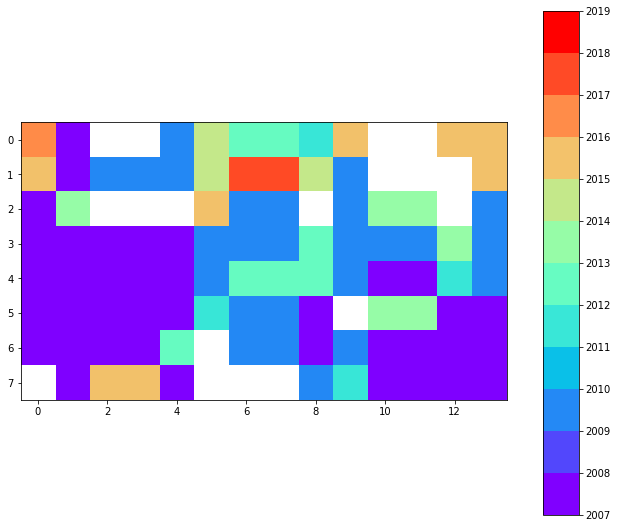

In [58]:
bins = len(idx_starts)

cmap = plt.get_cmap("rainbow")
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

bounds = np.linspace(0, bins-1, bins) #third number is the amount of bins in the colorbar 0=0, 6 = ncolors, 7= nyears
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
im = axes.imshow(breaks_plot_years, cmap=cmap, vmin=0, vmax=bins, norm=norm)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax, ticks=range(bins))
labels = cbar_ax.set_yticklabels(ticklist)

plt.savefig("./output/picture.png")
plt.show()


In [45]:
# #this doesn't work yet

# output_raster = gdal.GetDriverByName('GTiff').Create('myraster.tif',cols, rows, 1 ,gdal.GDT_Float32)  # Open the file

# output_raster.SetGeoTransform(geotransform)  # Specify its coordinates
# srs = osr.SpatialReference()                 # Establish its coordinate encoding
# srs.ImportFromEPSG(4326)                     # This one specifies WGS84 lat long.
#                                              # Anyone know how to specify the 
#                                              # IAU2000:49900 Mars encoding?
# output_raster.SetProjection( srs.ExportToWkt() )   # Exports the coordinate system 
#                                                    # to the file
# output_raster.GetRasterBand(1).WriteArray(breaks_plot_years)   # Writes my array to the raster

# output_raster.FlushCache()

# output_raster

In [46]:
print(breaks_plot_years)
breaks_plot_years_norm = 1/(breaks_plot_years + 0.01)
print(breaks_plot_years_norm)

[[nan nan nan nan nan nan 11. 11. 11. nan nan nan nan nan]
 [nan nan nan nan nan 10.  0.  0. 12. nan nan nan nan nan]
 [nan nan 12. 12. nan 12. 12. 12. nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [nan nan 12. 12. nan 12. 12. 12. nan nan nan nan nan nan]
 [nan nan nan nan nan 12. 12. 12. nan nan nan nan nan nan]
 [12. nan 12. 12. nan 12. nan nan 12. nan nan nan nan nan]
 [nan nan nan nan 12. 12. 12. 12. nan nan nan nan nan nan]]
[[           nan            nan            nan            nan
             nan            nan 9.08265213e-02 9.08265213e-02
  9.08265213e-02            nan            nan            nan
             nan            nan]
 [           nan            nan            nan            nan
             nan 9.99000999e-02 1.00000000e+02 1.00000000e+02
  8.32639467e-02            nan            nan            nan
             nan            nan]
 [           nan            nan 8.32639467e-02 8.32639467e-02
             nan 8.32639467

In [ ]:
#cmap = plt.get_cmap("Oranges")

#cmaplist = [cmap(i) for i in range(cmap.N)]

#cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# viridis = cm.get_cmap('viridis', 12)
# print(viridis)
# print(viridis(0.56))

viridis = cm.get_cmap('rainbow', 256)
newcolors = viridis(np.linspace(0, 1, 256))
pink = np.array([248/256, 24/256, 148/256, 0])
newcolors[:1, :] = pink
newcmp = ListedColormap(newcolors)

In [ ]:
print(latitude)
print(xpixelsize)
print(cols)
print(longitude)
print(ypixelsize)
print(rows)

In [ ]:
from folium.plugins import FloatImage
import base64
m = folium.folium.Map(location = (latitude,longitude),tiles = "Stamen Terrain",zoom_start=13)

# if not all data is 
#rows = 200
#cols = 200


# bounds = [[lat_min, lon_min], [lat_max, lon_max]]

folium.raster_layers.ImageOverlay(
    image=breaks_plot_years_norm,
    bounds=[[latitude, longitude], [latitude + rows*xpixelsize, longitude + cols*xpixelsize]],
    colormap = newcmp
).add_to(m)
img = "output/picture.png" 


####
resolution, width, height = 75, 4,4
encoded = base64.b64encode(open("output/picture.png", 'rb').read()).decode()
from folium import IFrame

html = '<img src="data:image/png;base64,{}">'.format
iframe = IFrame(html(encoded), width=(width*resolution)+20, height=(height*resolution)+20)
popup = folium.Popup(iframe, max_width=2650)

icon = folium.Icon(color="red", icon="ok")
marker = folium.Marker(location=[latitude, longitude], popup=popup, icon=icon)
marker.add_to(m)
####

m.save(os.path.join('output/PortugalBigger.html'))
m